<a href="https://colab.research.google.com/github/cuducquang/Deep-Learning/blob/main/resnet%2Bcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Setup Frameworks and Libraries

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Concatenate, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

## 2 - EDA

In [3]:
data = np.load('dataset_dev_3000.npz')
X = data['X']   # Input images
y = data['y']   # Multi-target labels

# 2. Decompose Targets for Analysis
# y[:, 0]: Target A (Classification 0-9)
# y[:, 1]: Target B (Classification 0-31)
# y[:, 2]: Target C (Regression 0-1)
y_target_A = y[:, 0].astype(int)
y_target_B = y[:, 1].astype(int)
y_target_C = y[:, 2]

print("Data Loaded Successfully")
print(f"X Shape: {X.shape} | Type: {X.dtype}")
print(f"y Shape: {y.shape} | Type: {y.dtype}")
print("-" * 30)
print(f"Target A (Class 10): Unique values: {np.unique(y_target_A)}")
print(f"Target B (Class 32): Unique values count: {len(np.unique(y_target_B))}")
print(f"Target C (Regress):  Range [{y_target_C.min():.4f}, {y_target_C.max():.4f}]")

Data Loaded Successfully
X Shape: (3000, 32, 32) | Type: float32
y Shape: (3000, 3) | Type: float32
------------------------------
Target A (Class 10): Unique values: [0 1 2 3 4 5 6 7 8 9]
Target B (Class 32): Unique values count: 32
Target C (Regress):  Range [0.0003, 0.9996]


In [4]:
# Check Pixel Intensity Statistics
print(" Pixel Value Statistics:")
print(f"Min : {X.min()}")
print(f"Max : {X.max()}")
print(f"Mean: {X.mean():.2f}")
print(f"Std : {X.std():.2f}")

# Check for Channel Dimension
if X.ndim == 3:
    print("Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.")
else:
    print("Images already have channel dimension.")

 Pixel Value Statistics:
Min : 5.5413776863133535e-05
Max : 6.8485941886901855
Mean: 0.81
Std : 0.74
Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.


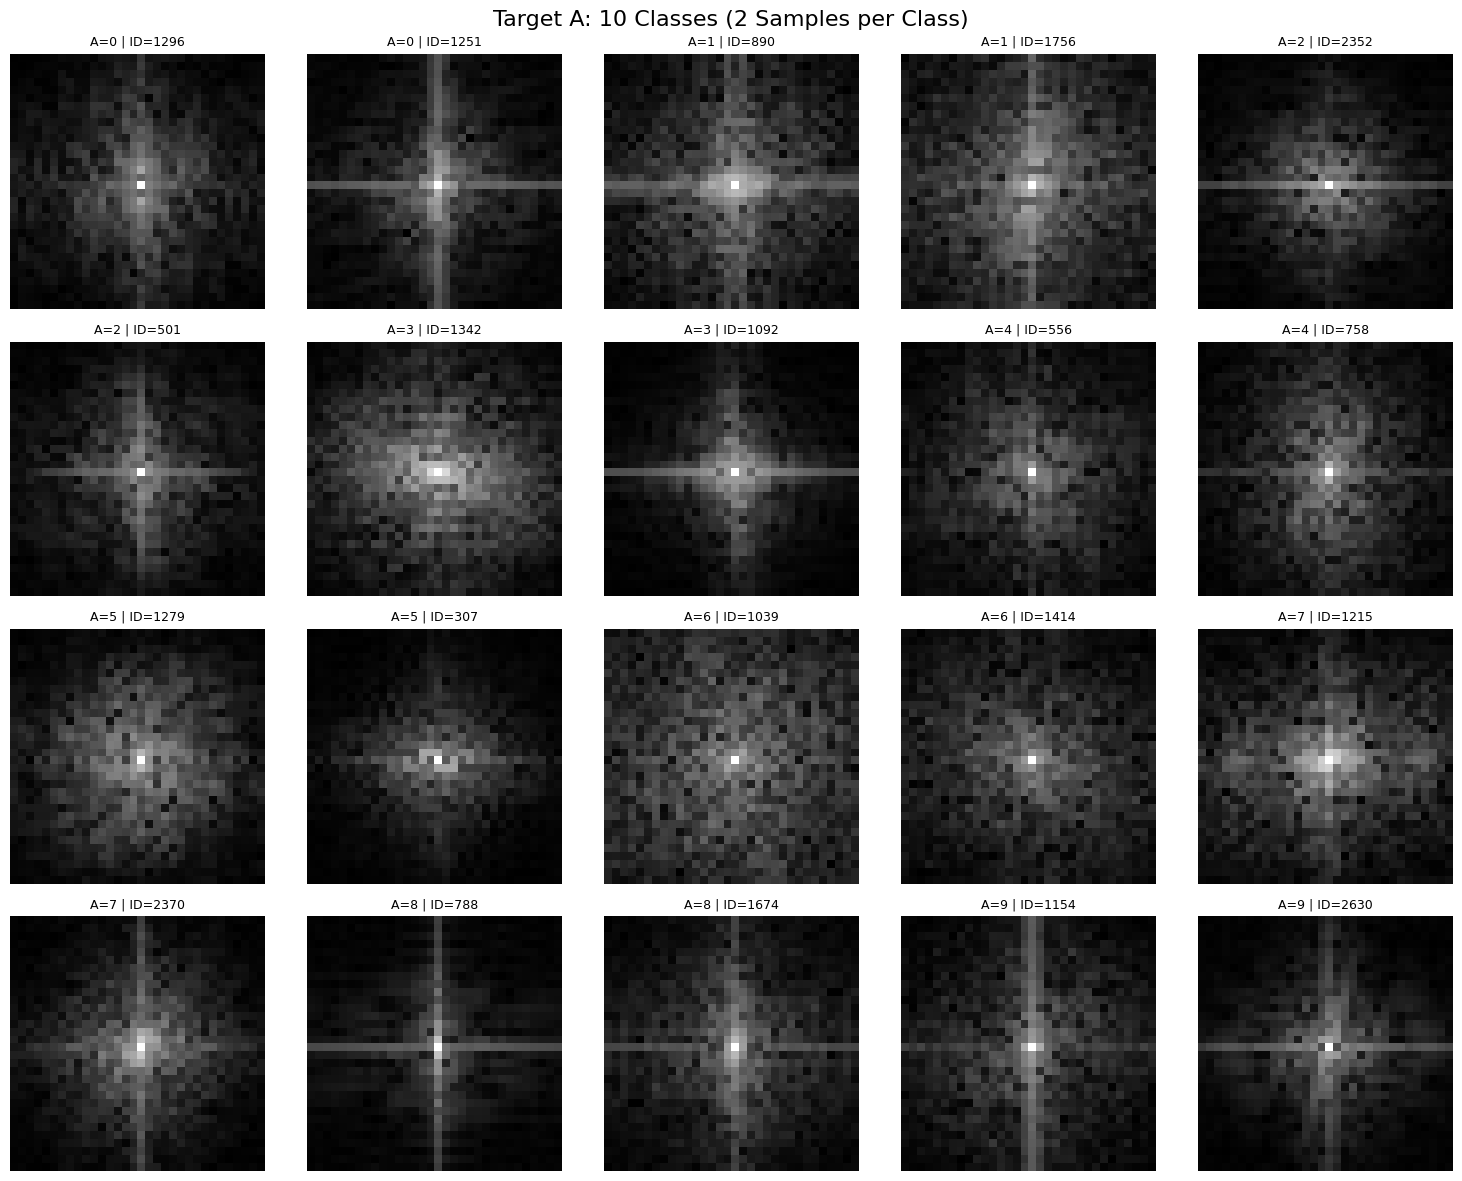

In [5]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

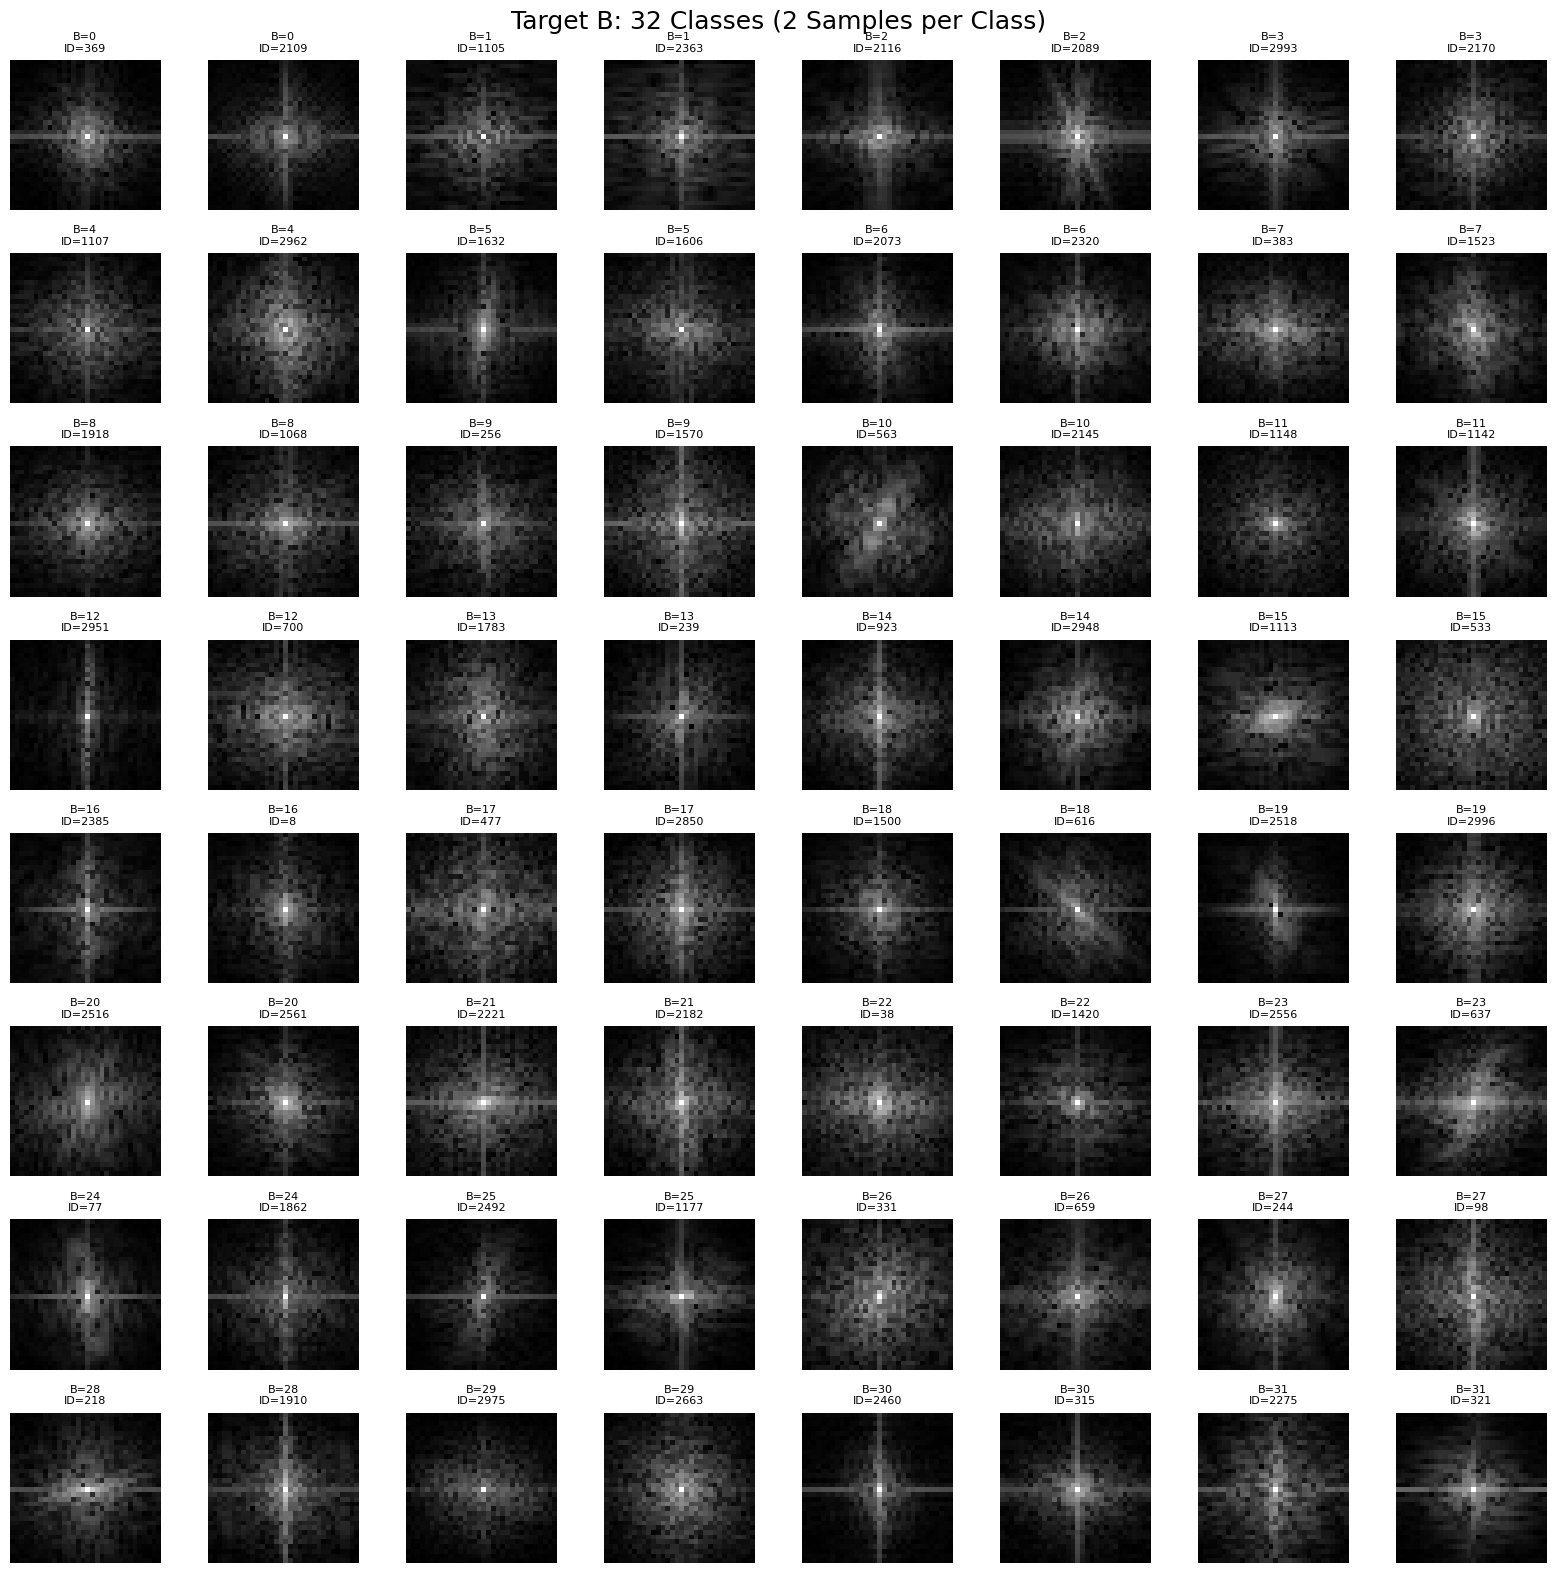

In [6]:
# -------- FIGURE 2: Target B --------
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

plot_idx = 0
for cls in range(32):
    cls_indices = np.where(y_target_B == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"B={cls}\nID={idx}", fontsize=8)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target B: 32 Classes (2 Samples per Class)", fontsize=18)
plt.tight_layout()
plt.show()

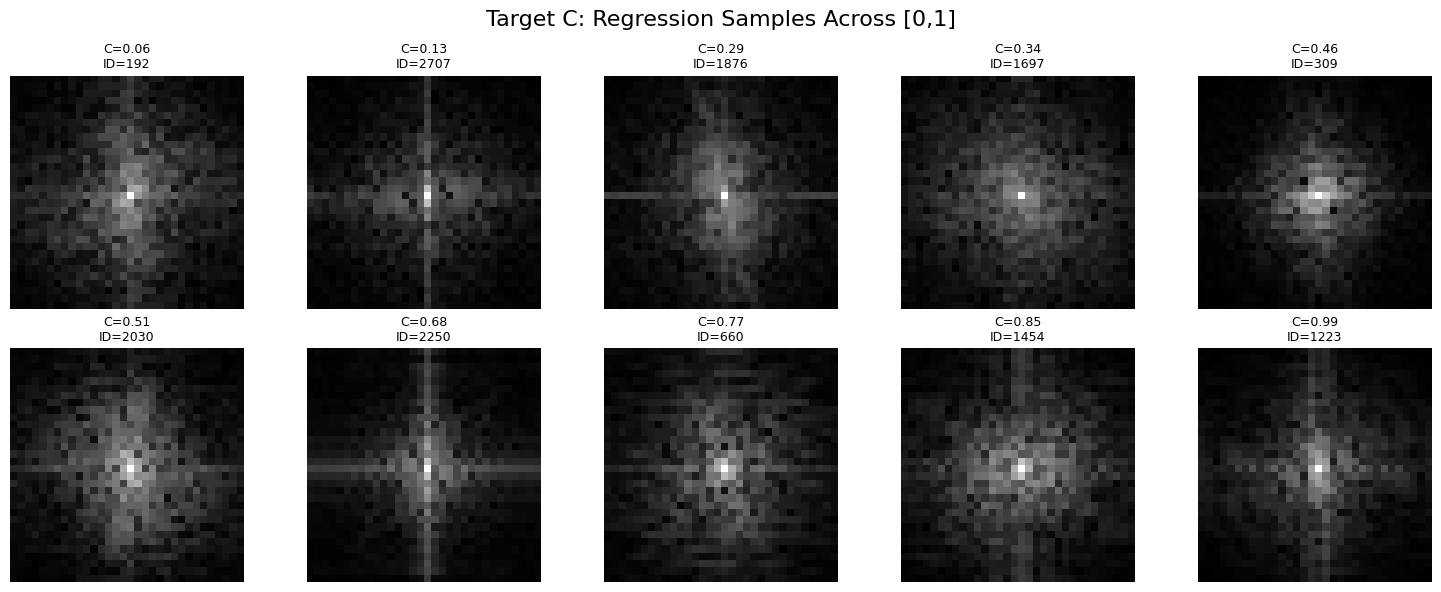

In [7]:
# -------- FIGURE 3: Target C --------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

bins = np.linspace(0, 1, 11)

selected_indices = []
for i in range(10):
    bin_indices = np.where(
        (y_target_C >= bins[i]) & (y_target_C < bins[i+1])
    )[0]
    if len(bin_indices) > 0:
        selected_indices.append(np.random.choice(bin_indices))

for ax, idx in zip(axes, selected_indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"C={y_target_C[idx]:.2f}\nID={idx}", fontsize=9)
    ax.axis('off')

fig.suptitle("Target C: Regression Samples Across [0,1]", fontsize=16)
plt.tight_layout()
plt.show()

Target A Balance Check: {np.int64(0): np.int64(290), np.int64(1): np.int64(304), np.int64(2): np.int64(311), np.int64(3): np.int64(305), np.int64(4): np.int64(306), np.int64(5): np.int64(294), np.int64(6): np.int64(290), np.int64(7): np.int64(291), np.int64(8): np.int64(310), np.int64(9): np.int64(299)}


/tmp/ipython-input-1890465473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_A, palette='viridis')


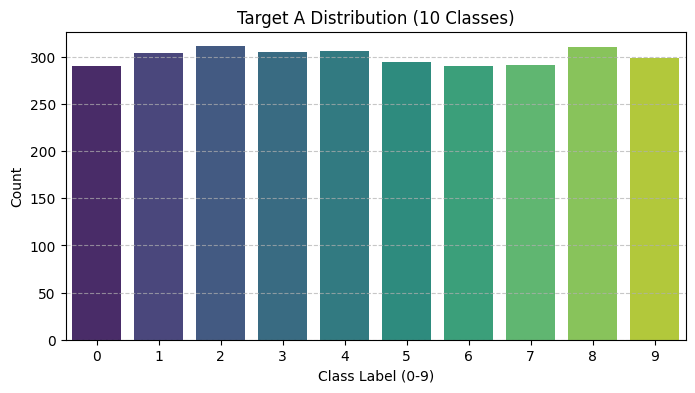

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_target_A, palette='viridis')
plt.title("Target A Distribution (10 Classes)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Check exact counts
unique, counts = np.unique(y_target_A, return_counts=True)
print("Target A Balance Check:", dict(zip(unique, counts)))
plt.show()

/tmp/ipython-input-1059615394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_B, palette='magma')


Target B - Min samples per class: 75
Target B - Max samples per class: 113


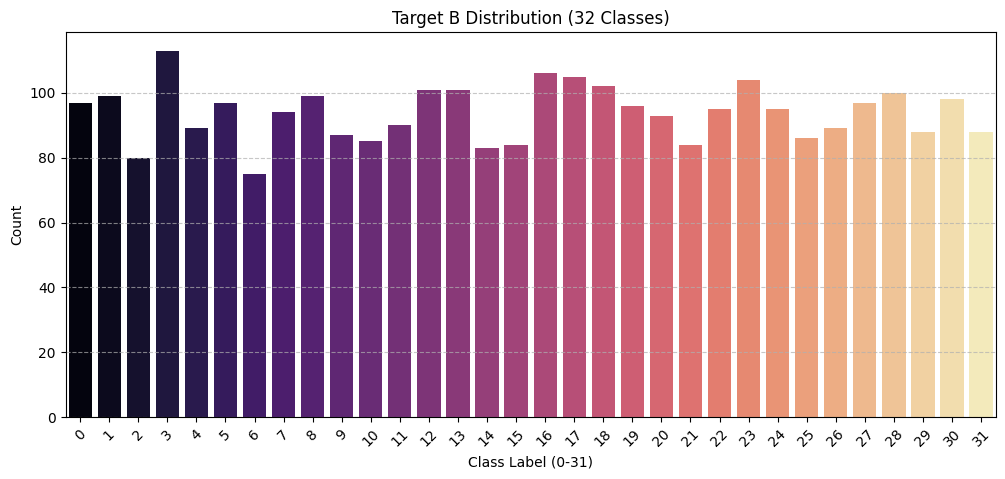

In [9]:
plt.figure(figsize=(12, 5))
sns.countplot(x=y_target_B, palette='magma')
plt.title("Target B Distribution (32 Classes)")
plt.xlabel("Class Label (0-31)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Statistics for Target B
unique_b, counts_b = np.unique(y_target_B, return_counts=True)
print(f"Target B - Min samples per class: {counts_b.min()}")
print(f"Target B - Max samples per class: {counts_b.max()}")
plt.show()

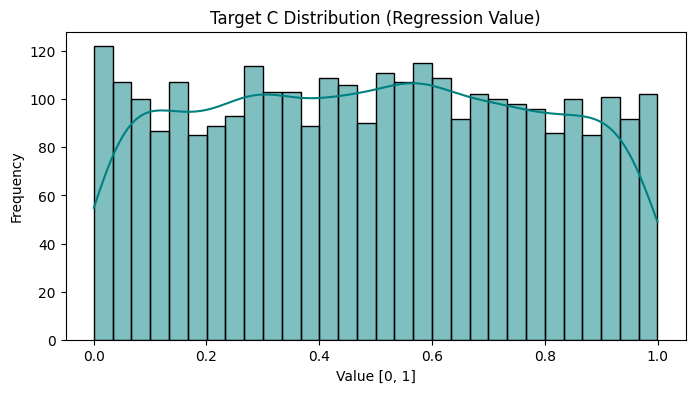

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(y_target_C, kde=True, bins=30, color='teal')
plt.title("Target C Distribution (Regression Value)")
plt.xlabel("Value [0, 1]")
plt.ylabel("Frequency")
plt.show()

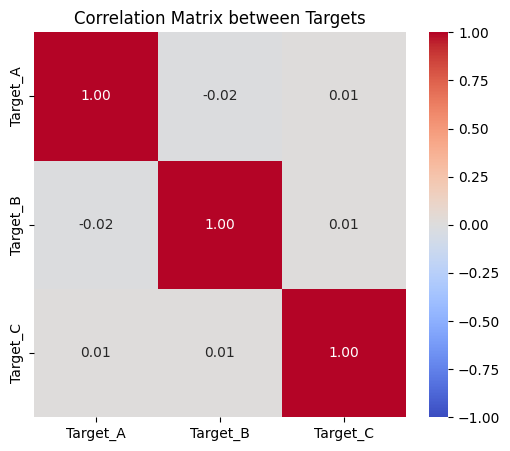

In [11]:
# Create a DataFrame for correlation checking
df_targets = pd.DataFrame({
    'Target_A': y_target_A,
    'Target_B': y_target_B,
    'Target_C': y_target_C
})

# Compute Correlation Matrix
corr_matrix = df_targets.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Targets")
plt.show()

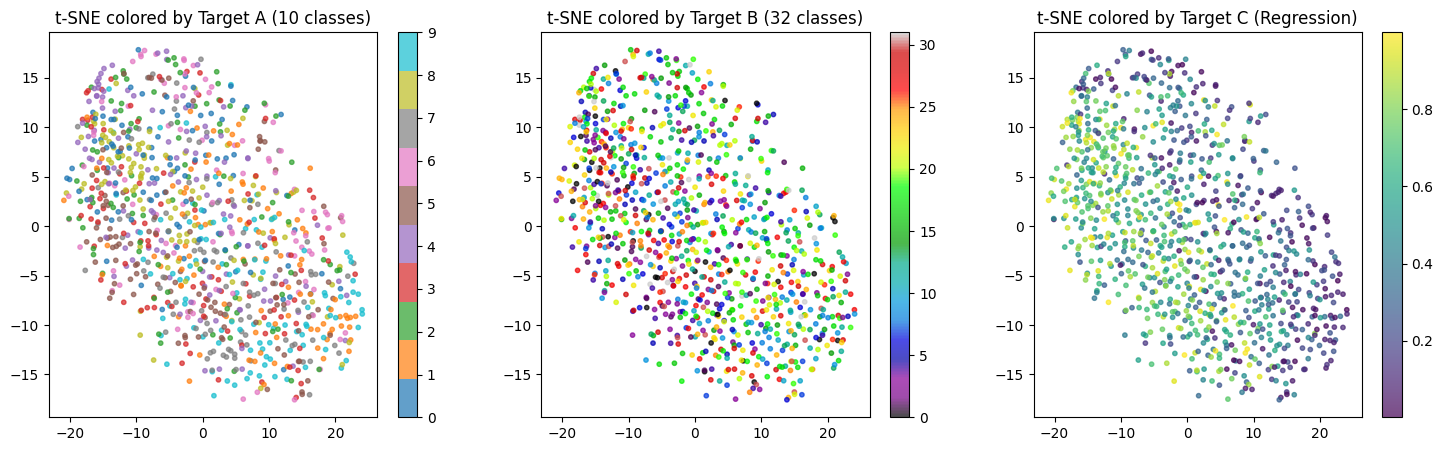

In [12]:
# Subsample for speed (1000 samples)
idx_subset = np.random.choice(len(X), 1000, replace=False)
X_tsne_input = X[idx_subset].reshape(1000, -1)
y_tsne_A = y_target_A[idx_subset]
y_tsne_B = y_target_B[idx_subset]
y_tsne_C = y_target_C[idx_subset]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_tsne_input)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot colored by Target A
scatter1 = axes[0].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_A, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("t-SNE colored by Target A (10 classes)")
plt.colorbar(scatter1, ax=axes[0])

# Plot colored by Target B
scatter2 = axes[1].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_B, cmap='nipy_spectral', s=10, alpha=0.7)
axes[1].set_title("t-SNE colored by Target B (32 classes)")
plt.colorbar(scatter2, ax=axes[1])

# Plot colored by Target C
scatter3 = axes[2].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_C, cmap='viridis', s=10, alpha=0.7)
axes[2].set_title("t-SNE colored by Target C (Regression)")
plt.colorbar(scatter3, ax=axes[2])

plt.show()

## 3 - Data Preprocessing

In [13]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# -------------------------------
# IMAGE PREPROCESSING FUNCTIONS
# -------------------------------

def log_scale(img):
    return np.log1p(img)

def remove_dc_center(img, radius=3):
    h, w = img.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    mask = (X - cx) ** 2 + (Y - cy) ** 2 <= radius ** 2
    img = img.copy()
    img[mask] = np.median(img)
    return img

def gaussian_denoise(img):
    return cv2.GaussianBlur(img, (3, 3), 0)

def clahe_enhance(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = (img * 255).astype(np.uint8)
    img = clahe.apply(img)
    return img.astype(np.float32) / 255.0

# -------------------------------
# APPLY PIPELINE TO WHOLE DATASET
# -------------------------------

def preprocess_image(img):
    # 1) normalize
    img = img.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    # 2) log scale for frequency-like data
    img = log_scale(img)

    # 3) remove strong DC spike in center
    img = remove_dc_center(img)

    # 4) light denoising
    img = gaussian_denoise(img)

    # 5) contrast enhancement
    img = clahe_enhance(img)

    return img


# Apply to X (shape: N, 32, 32)
X_processed = np.array([preprocess_image(x) for x in X])

# Add channel dimension -> (N, 32, 32, 1)
X_processed = np.expand_dims(X_processed, axis=-1)


# -------------------------------
# TARGETS (unchanged logically)
# -------------------------------

y_A_raw = y[:, 0].astype(int)   # 0–9
y_B_raw = y[:, 1].astype(int)   # 0–31
y_C_raw = y[:, 2].astype(float) # regression


# -------------------------------
# TRAIN / VAL / TEST SPLIT
# -------------------------------

X_train, X_temp, yA_train, yA_temp, yB_train, yB_temp, yC_train, yC_temp = train_test_split(
    X_processed, y_A_raw, y_B_raw, y_C_raw,
    test_size=0.3, random_state=42, stratify=y_B_raw
)

X_val, X_test, yA_val, yA_test, yB_val, yB_test, yC_val, yC_test = train_test_split(
    X_temp, yA_temp, yB_temp, yC_temp,
    test_size=0.5, random_state=42, stratify=yB_temp
)

# reshape regression output
yC_train_reg = yC_train.reshape(-1, 1)
yC_val_reg   = yC_val.reshape(-1, 1)
yC_test_reg  = yC_test.reshape(-1, 1)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (2100, 32, 32, 1)
Val: (450, 32, 32, 1)
Test: (450, 32, 32, 1)


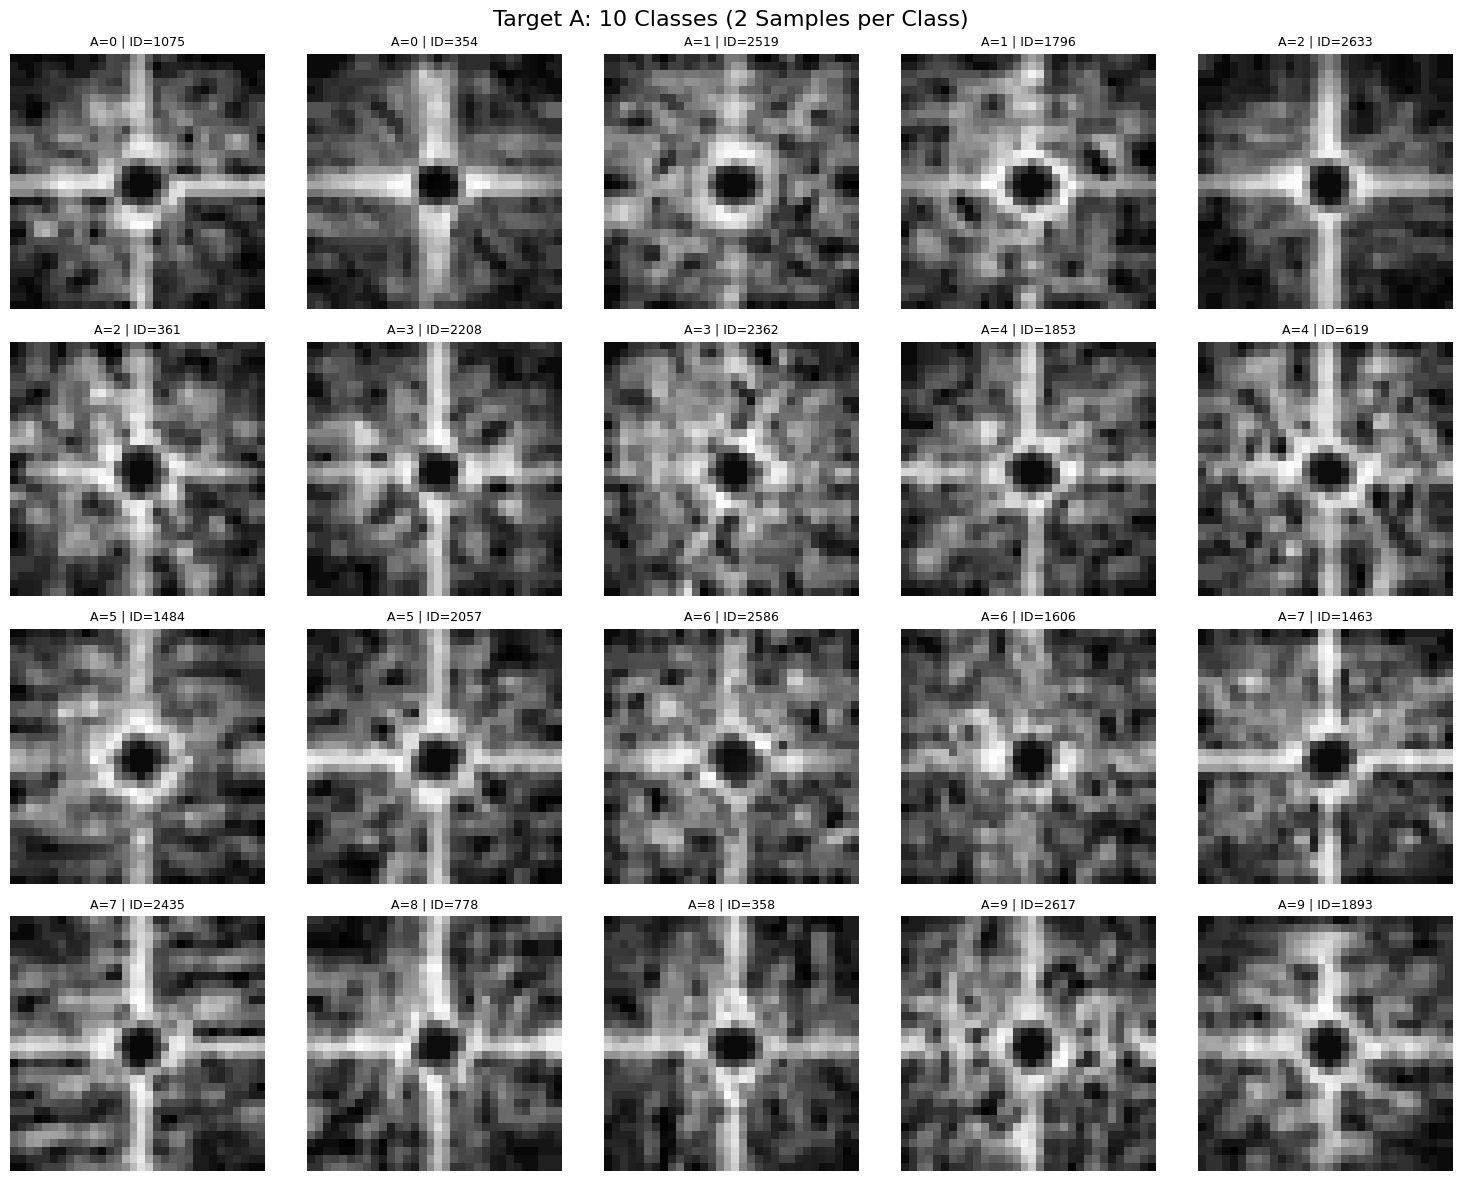

In [14]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X_processed[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

class MultiTaskDataset(Dataset):
    def __init__(self, X, yA, yB, yC):
        self.X = torch.tensor(X, dtype=torch.float32)  # (N,32,32,1)
        self.yA = torch.tensor(yA, dtype=torch.long)
        self.yB = torch.tensor(yB, dtype=torch.long)
        self.yC = torch.tensor(yC, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1)  # (1,32,32)
        return (
            x,
            torch.tensor(self.yA[idx], dtype=torch.long),
            torch.tensor(self.yB[idx], dtype=torch.long),
            torch.tensor(self.yC[idx], dtype=torch.float32)
        )


In [57]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(8),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.Resize((224, 224)),  # ViT requires fixed size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [58]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [59]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [60]:
from torch.utils.data import DataLoader


train_loader = DataLoader(
    MultiTaskDataset(X_train, yA_train, yB_train, yC_train_reg),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    MultiTaskDataset(X_val, yA_val, yB_val, yC_val_reg),
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    MultiTaskDataset(X_test, yA_test, yB_test, yC_test_reg),
    batch_size=32,
    shuffle=False
)


## 4 - Model Architecture

In [74]:
import torch
import torch.nn as nn
import torchvision.models as models

class CNNTransformerMultiTask(nn.Module):
    def __init__(
        self,
        num_classes_A=10,
        num_classes_B=32,
        d_model=256,
        nhead=8,
        num_layers=4,
        dim_feedforward=512,
        dropout=0.1
    ):
        super().__init__()

        # CNN backbone (remove final FC layer)
        backbone = models.resnet18(pretrained=True)
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.cnn = nn.Sequential(*list(backbone.children())[:-2])  # output: (B, 512, H/32, W/32)
        self.cnn_out_channels = 512

        # Project CNN features to transformer dimension
        self.proj = nn.Conv2d(self.cnn_out_channels, d_model, kernel_size=1)

        # Positional embedding (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, 1000, d_model))  # will be sliced dynamically

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Heads
        self.head_A = nn.Linear(d_model, num_classes_A)
        self.head_B = nn.Linear(d_model, num_classes_B)
        self.head_C = nn.Linear(d_model, 1)

    def forward(self, x):
        B = x.size(0)

        # CNN feature extraction
        feat = self.cnn(x)                     # (B, C, H, W)
        feat = self.proj(feat)                 # (B, d_model, H, W)
        feat = feat.flatten(2).transpose(1, 2)  # (B, N, d_model), N = H*W

        # Add positional embeddings
        pos = self.pos_embed[:, :feat.size(1), :]
        feat = feat + pos

        # Transformer
        tokens = self.transformer(feat)        # (B, N, d_model)

        # Global token (mean pooling)
        pooled = tokens.mean(dim=1)            # (B, d_model)

        # Task heads
        outA = self.head_A(pooled)             # (B, num_classes_A)
        outB = self.head_B(pooled)             # (B, num_classes_B)
        outC = self.head_C(pooled)             # (B, 1)

        return outA, outB, outC


In [75]:
model = CNNTransformerMultiTask()

In [76]:
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()
lossC = nn.SmoothL1Loss()  # Huber equivalent

def compute_loss(preds, targets):
    pA, pB, pC = preds
    yA, yB, yC = targets

    return (
        lossA(pA, yA) +
        2.0 * lossB(pB, yB) +
        0.3 * lossC(pC.squeeze(), yC)
    )


In [77]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [78]:
criterions = {
    'A': torch.nn.CrossEntropyLoss(),
    'B': torch.nn.CrossEntropyLoss(),
    'C': torch.nn.SmoothL1Loss()  # Huber
}


In [79]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

from torch.optim.lr_scheduler import LambdaLR

def warmup_lr(step):
    warmup_steps = 500
    if step < warmup_steps:
        return step / warmup_steps
    return 1.0

scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr)


In [80]:
def train_one_epoch(model, loader, optimizer, criterions, device, loss_weights=None):
    model.train()
    total_loss, correctA, correctB, total, total_maeC = 0, 0, 0, 0, 0

    if loss_weights is None:
        loss_weights = {'A': 1.0, 'B': 1.0, 'C': 1.0}

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        optimizer.zero_grad()
        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC)

        loss = (
            loss_weights['A'] * lossA +
            loss_weights['B'] * lossB +
            loss_weights['C'] * lossC
        )
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        correctA += (outA.argmax(1) == yA).sum().item()
        correctB += (outB.argmax(1) == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(outC.squeeze() - yC).sum().item()

    return (
        total_loss / len(loader),
        correctA / total,
        correctB / total,
        total_maeC / total
    )


In [81]:
@torch.no_grad()
def validate(model, loader, criterions, device, loss_weights=None):
    model.eval()
    total_loss, correctA, correctB, total, total_maeC = 0, 0, 0, 0, 0

    if loss_weights is None:
        loss_weights = {'A': 1.0, 'B': 1.0, 'C': 1.0}

    for x, yA, yB, yC in loader:
        x, yA, yB, yC = x.to(device), yA.to(device), yB.to(device), yC.to(device)

        outA, outB, outC = model(x)

        lossA = criterions['A'](outA, yA)
        lossB = criterions['B'](outB, yB)
        lossC = criterions['C'](outC.squeeze(), yC)

        loss = (
            loss_weights['A'] * lossA +
            loss_weights['B'] * lossB +
            loss_weights['C'] * lossC
        )

        total_loss += loss.item()
        correctA += (outA.argmax(1) == yA).sum().item()
        correctB += (outB.argmax(1) == yB).sum().item()
        total += yA.size(0)
        total_maeC += torch.abs(outC.squeeze() - yC).sum().item()

    return (
        total_loss / len(loader),
        correctA / total,
        correctB / total,
        total_maeC / total
    )


In [82]:
for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.transformer.parameters():
    param.requires_grad = False


In [83]:
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3
)

WARMUP_EPOCHS = 20

for epoch in range(WARMUP_EPOCHS):
    train_loss, train_accA, train_accB, train_maeC = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss, val_accA, val_accB, val_maeC = validate(
        model, val_loader, criterions, device
    )

    print(f"[Warm-up {epoch+1}/{WARMUP_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"A Acc: {train_accA:.4f} | B Acc: {train_accB:.4f} | C MAE: {train_maeC:.4f} || "
          f"Val Loss: {val_loss:.4f} | "
          f"A Acc: {val_accA:.4f} | B Acc: {val_accB:.4f} | C MAE: {val_maeC:.4f}")


/tmp/ipython-input-1060929610.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-1060929610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-1060929610.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In 

[Warm-up 1/20] Train Loss: 5.9851 | A Acc: 0.1081 | B Acc: 0.0305 | C MAE: 10.0906 || Val Loss: 5.8230 | A Acc: 0.1244 | B Acc: 0.0333 | C MAE: 8.0062
[Warm-up 2/20] Train Loss: 5.8437 | A Acc: 0.1414 | B Acc: 0.0367 | C MAE: 8.4652 || Val Loss: 5.8846 | A Acc: 0.1356 | B Acc: 0.0289 | C MAE: 8.0962
[Warm-up 3/20] Train Loss: 5.7618 | A Acc: 0.1638 | B Acc: 0.0505 | C MAE: 8.5728 || Val Loss: 5.9868 | A Acc: 0.1378 | B Acc: 0.0444 | C MAE: 8.1081
[Warm-up 4/20] Train Loss: 5.7009 | A Acc: 0.1648 | B Acc: 0.0576 | C MAE: 8.6044 || Val Loss: 5.9568 | A Acc: 0.1378 | B Acc: 0.0244 | C MAE: 7.9543
[Warm-up 5/20] Train Loss: 5.5594 | A Acc: 0.1971 | B Acc: 0.0862 | C MAE: 8.5011 || Val Loss: 6.0359 | A Acc: 0.1378 | B Acc: 0.0444 | C MAE: 8.0175
[Warm-up 6/20] Train Loss: 5.5069 | A Acc: 0.2157 | B Acc: 0.0838 | C MAE: 8.4941 || Val Loss: 6.0811 | A Acc: 0.1356 | B Acc: 0.0511 | C MAE: 8.0477
[Warm-up 7/20] Train Loss: 5.4444 | A Acc: 0.2248 | B Acc: 0.1100 | C MAE: 8.5182 || Val Loss: 6.07

In [84]:
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_accA_list = []
val_accA_list = []
train_accB_list = []
val_accB_list = []
train_maeC_list = []
val_maeC_list = []

FULL_EPOCHS = 100

for epoch in range(FULL_EPOCHS):
    train_loss, train_accA, train_accB, train_maeC = train_one_epoch(
        model, train_loader, optimizer, criterions, device
    )
    val_loss, val_accA, val_accB, val_maeC = validate(
        model, val_loader, criterions, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accA_list.append(train_accA)
    val_accA_list.append(val_accA)
    train_accB_list.append(train_accB)
    val_accB_list.append(val_accB)
    train_maeC_list.append(train_maeC)
    val_maeC_list.append(val_maeC)

    print(f"[Full {epoch+1}/{FULL_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | "
          f"A Acc: {train_accA:.4f} | B Acc: {train_accB:.4f} | C MAE: {train_maeC:.4f} || "
          f"Val Loss: {val_loss:.4f} | "
          f"A Acc: {val_accA:.4f} | B Acc: {val_accB:.4f} | C MAE: {val_maeC:.4f}")


/tmp/ipython-input-1060929610.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yA[idx], dtype=torch.long),
/tmp/ipython-input-1060929610.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yB[idx], dtype=torch.long),
/tmp/ipython-input-1060929610.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.yC[idx], dtype=torch.float32)


[Full 1/100] Train Loss: 5.2530 | A Acc: 0.2438 | B Acc: 0.1424 | C MAE: 7.9958 || Val Loss: 6.4453 | A Acc: 0.1511 | B Acc: 0.0467 | C MAE: 7.9087
[Full 2/100] Train Loss: 4.8661 | A Acc: 0.3024 | B Acc: 0.2124 | C MAE: 7.9983 || Val Loss: 6.6682 | A Acc: 0.1489 | B Acc: 0.0244 | C MAE: 7.9245
[Full 3/100] Train Loss: 4.4989 | A Acc: 0.3576 | B Acc: 0.2743 | C MAE: 7.9899 || Val Loss: 6.7432 | A Acc: 0.1422 | B Acc: 0.0333 | C MAE: 7.9117
[Full 4/100] Train Loss: 4.1169 | A Acc: 0.4148 | B Acc: 0.3471 | C MAE: 8.0064 || Val Loss: 6.8657 | A Acc: 0.1800 | B Acc: 0.0222 | C MAE: 7.9456
[Full 5/100] Train Loss: 3.6545 | A Acc: 0.4943 | B Acc: 0.4267 | C MAE: 8.0019 || Val Loss: 7.3470 | A Acc: 0.1667 | B Acc: 0.0267 | C MAE: 7.9060
[Full 6/100] Train Loss: 3.3090 | A Acc: 0.5300 | B Acc: 0.5024 | C MAE: 8.0585 || Val Loss: 7.5432 | A Acc: 0.1578 | B Acc: 0.0289 | C MAE: 7.9194
[Full 7/100] Train Loss: 2.8926 | A Acc: 0.5890 | B Acc: 0.5724 | C MAE: 8.0408 || Val Loss: 7.5661 | A Acc: 0.1

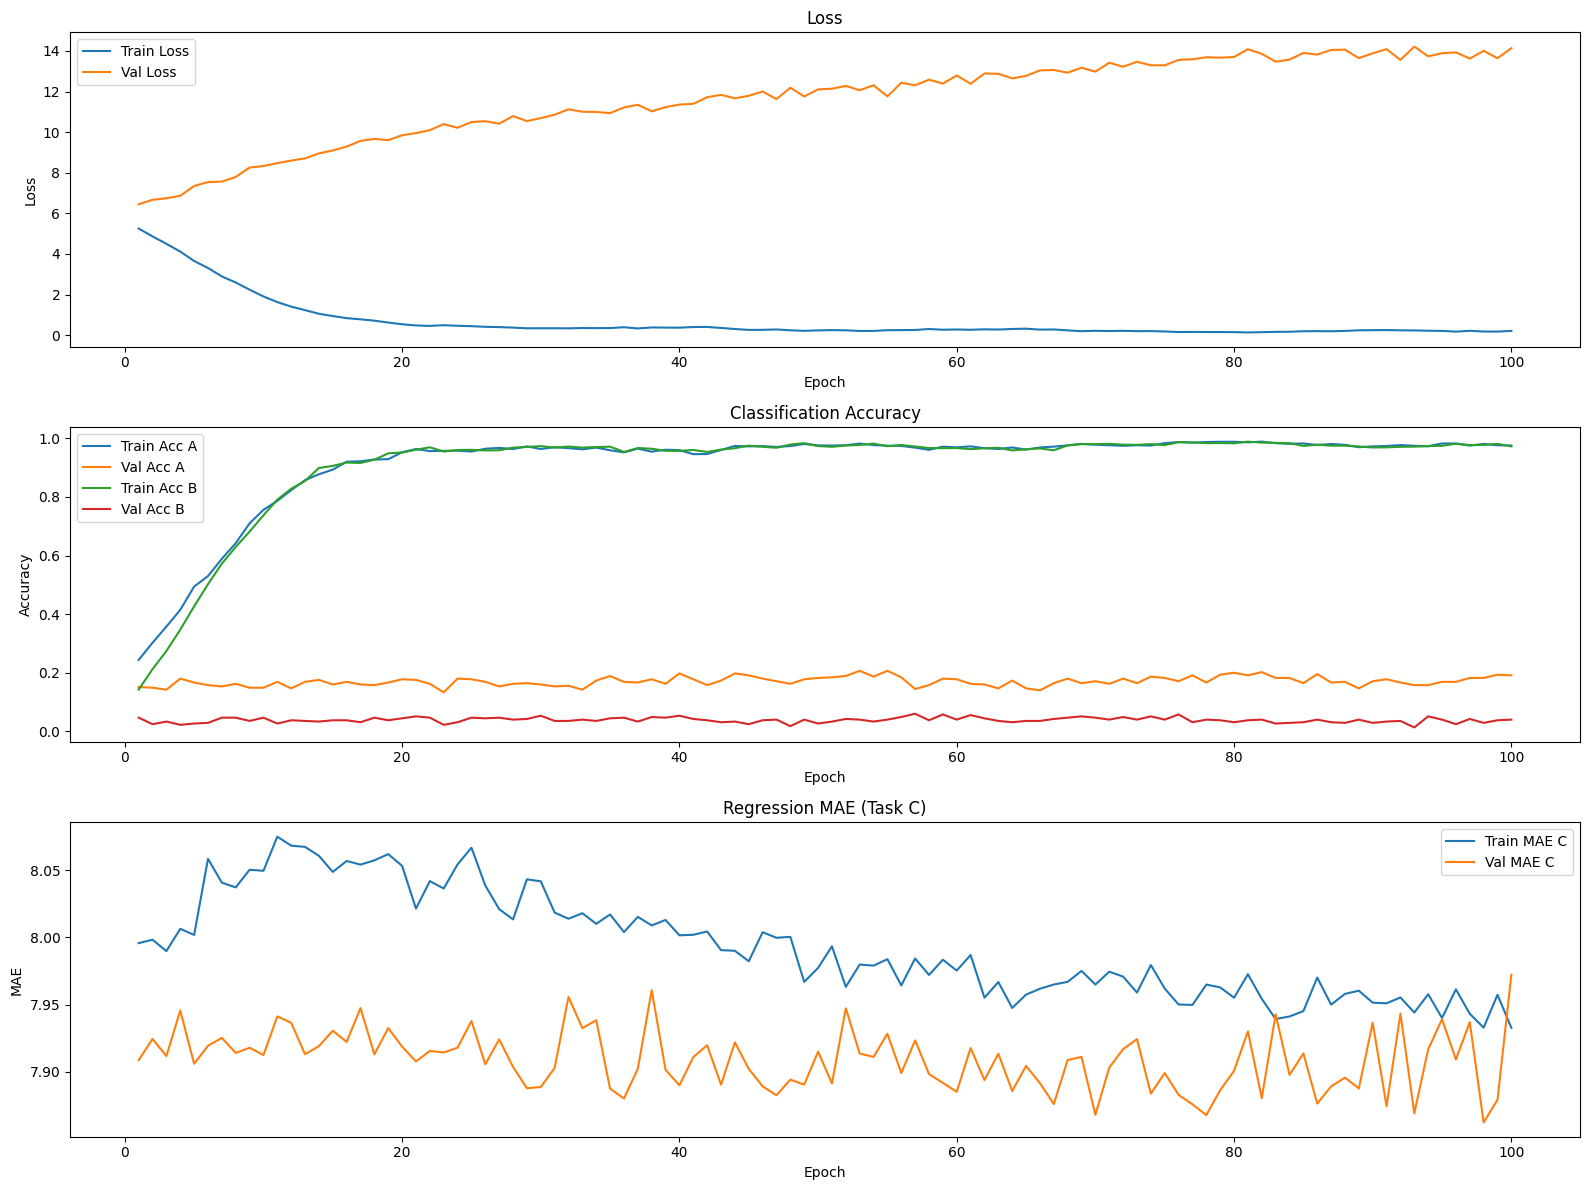

In [86]:
import matplotlib.pyplot as plt

epochs = range(1, FULL_EPOCHS + 1)

plt.figure(figsize=(16, 12))

# Loss
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy A & B
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accA_list, label='Train Acc A')
plt.plot(epochs, val_accA_list, label='Val Acc A')
plt.plot(epochs, train_accB_list, label='Train Acc B')
plt.plot(epochs, val_accB_list, label='Val Acc B')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# MAE C
plt.subplot(3, 1, 3)
plt.plot(epochs, train_maeC_list, label='Train MAE C')
plt.plot(epochs, val_maeC_list, label='Val MAE C')
plt.title('Regression MAE (Task C)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()
